<a href="https://colab.research.google.com/github/ParkHeeseung/Generative_Model/blob/master/%EC%BB%B4%ED%93%A8%ED%84%B0%EA%B3%B5%ED%95%99%EB%B6%80_20163113_%EB%B0%95%ED%9D%AC%EC%8A%B9_Generative_Model_using_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Generative Model using Autoencode


컴퓨터공학부 20163113 박희승


**과제 설명**


---


MNIST 데이터셋에 대해 autoencoder 기반 generative model을 구축한다.

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다. 

- Autoencoder의 encoder를 거쳐 나온 representation z를 ground truth(GT) label 별로 다른색을 주어 z의 분포를 가시화 한다.

- z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 수정한다.

- z 공간의 임의의 위치를 sampling한 후 학습된 decoder의 입력으로 주는 방식으로 generative model을 구축한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

- (* 이것 이외에도 의미있는 실험들을 스스로 생각하고 수행해 본다)

# Tensorflow 2.0과 Keras를 사용하기 위한 구성


In [0]:
#Tensorflow 2.0 install

!pip install -q --upgrade tf-nightly-gpu-2.0-preview

In [0]:
import tensorflow as tf                       # tensorflow import
from tensorflow.keras import models, layers  # keras import
import numpy as np #numpy import

print(tf.__version__)        # tensorflow version
print(tf.keras.__version__)  # keras version

2.0.0-dev20190519
2.2.4-tf


# MNIST
- mnist 데이터셋은 LeCun이 만든 숫자(digit) 손글씨 데이터셋입니다.
- 28x28크기의 이미지이며 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있습니다.

# FASHION_MNIST
- fashion-mnist 데이터셋은 옷 품목 데이터셋입니다.
- 기존의 mnist 데이터셋을 대신해 사용할 수 있습니다. 그 이유는 mnist와 동일한 이미지 크기(28x28)이며 동일한 학습 셋 (60,000), 테스트 셋(10,000)으로 나눌 수 있기 때문입니다.


---


본 과제에서는 fashion_mnist는 일반적인 mnist보다 조금 더 어려운 문제이고 같은 모델에 넣어 비교하기 위해 추가적으로 수행해보았습니다.

In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist
# fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalizing the images to the range of [0., 1.]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
# train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))
# test_images = np.reshape(test_images, (len(test_images), 28, 28, 1))

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


# 네트워크 모델 설계
- 인코더 모델과 디코더 모델을 결합하여 설계한 오토인코더 모델을 설계합니다.

---
본 과제에스는 Dense layer와 Convolution layer을 사용한 두 가지의 모델을 설계하였습니다.
또한, n_dim을 2와 3으로 설정하여 진행하였습니다.


In [0]:
n_dim = 2
# n_dim = 3

In [0]:
#CNN
# enc = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28,28, 1),padding='same'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
#     tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
#     tf.keras.layers.Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'),

#     tf.keras.layers.Flatten(),  
#     tf.keras.layers.Dense(n_dim),    
# ])

#Dence layer
enc = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28)),
    tf.keras.layers.Flatten(),  # 784
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense( 64, activation='relu'),
    tf.keras.layers.Dense( 32, activation='relu'),
    tf.keras.layers.Dense(n_dim),    
])

In [0]:
#CNN
# dec = tf.keras.models.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(n_dim,)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Reshape((4, 4, 8)),
#     tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.UpSampling2D((2, 2)),
#     tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.UpSampling2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
#     tf.keras.layers.UpSampling2D((2, 2)),
#     tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),

# ])

#Dence layer
dec = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_dim,)),
    tf.keras.layers.Dense( 32, activation='relu'),
    tf.keras.layers.Dense( 64, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(784, activation='sigmoid'),
    tf.keras.layers.Reshape(target_shape=(28,28)),
])


In [0]:
ae = tf.keras.models.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(28,28, 1)),
    tf.keras.layers.InputLayer(input_shape=(28,28)),

    enc,
    dec,
])

# 훈련 전, 모델 함수
- 훈련 전 모델이기 때문에 정상적으로 작동하지 않습니다.

In [0]:
# 훈련 전, 모델 함수

results = ae(train_images)

print('input shape:', train_images.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28)
output shape: (60000, 28, 28)


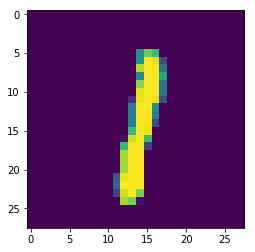

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

img_in  = train_images[1200]
plt.imshow(img_in.reshape(28, 28))


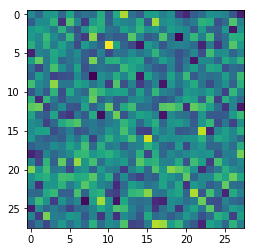

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt


img_pred = np.array(results[1200])
plt.imshow(img_pred.reshape(28, 28))

# 네트워크 모델 구조 확인

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
Total params: 219,554
Trainable params: 219,554
Non-trainable params: 0
_________________________________________________________________


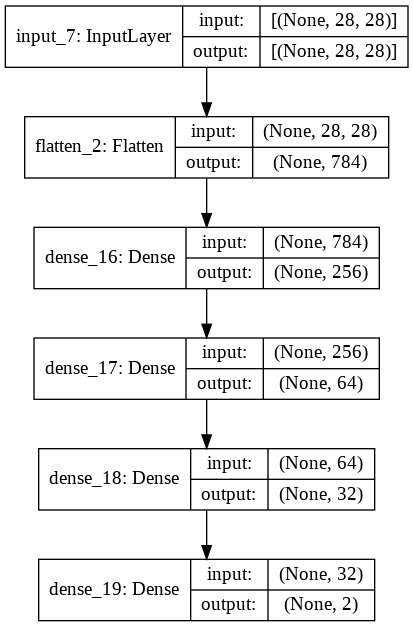

In [0]:
enc.summary()

tf.keras.utils.plot_model(enc, 'enc.png', show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 220,336
Trainable params: 220,336
Non-trainable params: 0
_________________________________________________________________


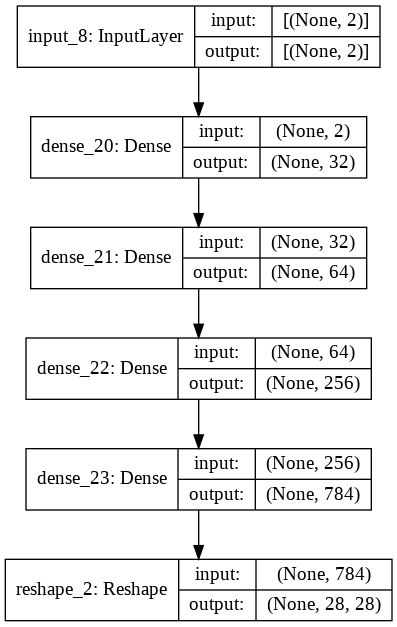

In [0]:
dec.summary()

tf.keras.utils.plot_model(dec, 'dec.png', show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 2)                 219554    
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28)            220336    
Total params: 439,890
Trainable params: 439,890
Non-trainable params: 0
_________________________________________________________________


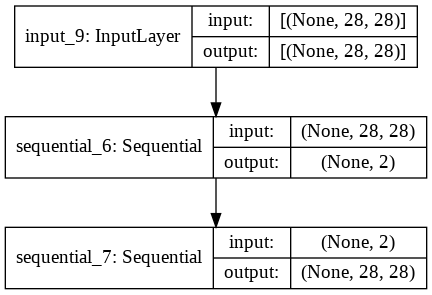

In [0]:
ae.summary()

tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

# 오토인코더 인스턴스 트레이닝
- optimizer은 Neural Network를 구성하는 알고리즘을 최적화시켜주는 도구입니다.
- loss function은 예측값과 실제값간의 차이를 표현한 일종의 수식입니다.
- metrics은 실제 화면상으로 출력되는 output으로 정확성을 판단합니다.


---

본 과제에서는 optimizer은 'adam'을 loss function은 'mean_squared_error'을 metrics은 'mae'를 등록하였습니다.

In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

epchos는 트레이닝을 총 몇 번 반복하는지를 의미합니다.

batch_size는 트레이닝을 할 때 몇 문항을 풀고 해답을 맞추는 지를 의미합니다.

---

본 과제에서는 epochs를 100을 batch_size는 256으로 설정하였습니다.


In [0]:
ae.fit(train_images, train_images, epochs=100, batch_size=256)

Epoch 1/100
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0716 - mae: 0.1497
Epoch 2/100
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0519 - mae: 0.1179
Epoch 3/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0476 - mae: 0.1085
Epoch 4/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0442 - mae: 0.1018
Epoch 5/100
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0424 - mae: 0.0982
Epoch 6/100
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0413 - mae: 0.0962
Epoch 7/100
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0406 - mae: 0.0949
Epoch 8/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0401 - mae: 0.0941
Epoch 9/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0396 - mae: 0.0930
Epoch 10/100
60000/60000 [==============================] - 4s 74us/sampl

#트레이닝이 끝난 오토인코더를 이용하기

---

# n_dim = 2인 경우

In [0]:
results = ae(train_images)

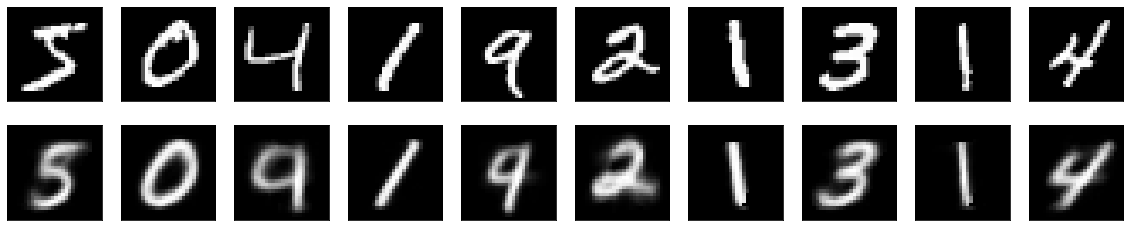

In [0]:
# 로딩된 MNIST 데이터 가시화

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(2, n, i + 1 + n)
    result = np.array(results[i])
    plt.imshow(result.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# n_dim = 3인 경우

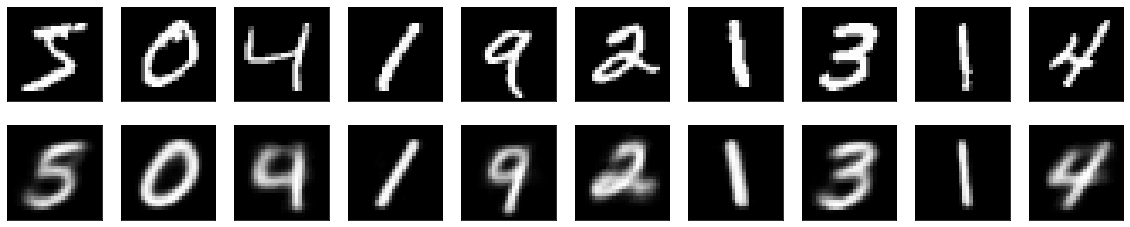

In [0]:
# 로딩된 MNIST 데이터 가시화

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(2, n, i + 1 + n)
    result = np.array(results[i])
    plt.imshow(result.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

n_dim = 2보다 n_dim = 3이 더 선명합니다.

#인코더 / 디코더 모델을 각각 따로 함수로서 활용

In [0]:
z = enc(train_images)
y_pred = dec(z)

#인코딩 결과 확인 및 디코딩 결과 확인

In [0]:
print(z[1204])

tf.Tensor([-5.143662  6.365181], shape=(2,), dtype=float32)


In [0]:

_x = -5 #@param {type: "slider", min: -10, max: 10}
_y = -3 #@param {type: "slider", min: -10, max: 10}

z_test = np.array([[_x, _y]])

print(z_test.shape)

(1, 2)


In [0]:
gen_test = dec(z_test)

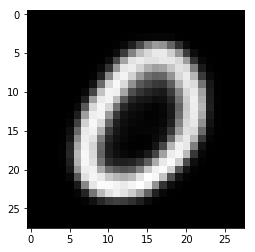

In [0]:
import matplotlib.pyplot as plt

img_gen = np.array(gen_test[0])
plt.imshow(img_gen.reshape(28, 28))


#인코딩 결과 가시화

---

#n_dim = 2인 경우

(5923, 2)
(6742, 2)
(5958, 2)
(5949, 2)


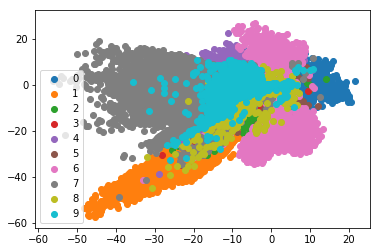

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt



z_0 = z[train_labels==0]
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_9.shape)

z_list = [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9]

for i in z_list:
  plt.scatter(i[:,0], i[:,1])

plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])



#n_dim = 3인 경우

(5923, 3)
(6742, 3)
(5958, 3)
(5949, 3)


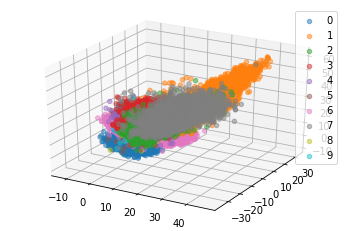

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


z_0 = z[train_labels==0]
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

z_list = [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_9.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in z_list:
  ax.scatter(i[:,0], i[:,1], i[:,2], alpha=0.5)


ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

#디코더를 이용한 Generative Model 구성


In [0]:

X_MIN = -30 #@param {type: "slider", min: -30, max: 230}
X_MAX = 17 #@param {type: "slider", min: -30, max: 30}
Y_MIN = -30 #@param {type: "slider", min: -30, max: 30}
Y_MAX = 20 #@param {type: "slider", min: -30, max: 30}
Z_MIN = -6 #@param {type: "slider", min: -30, max: 30}
Z_MAX = 13 #@param {type: "slider", min: -30, max: 30}


#n_dim = 2인 경우

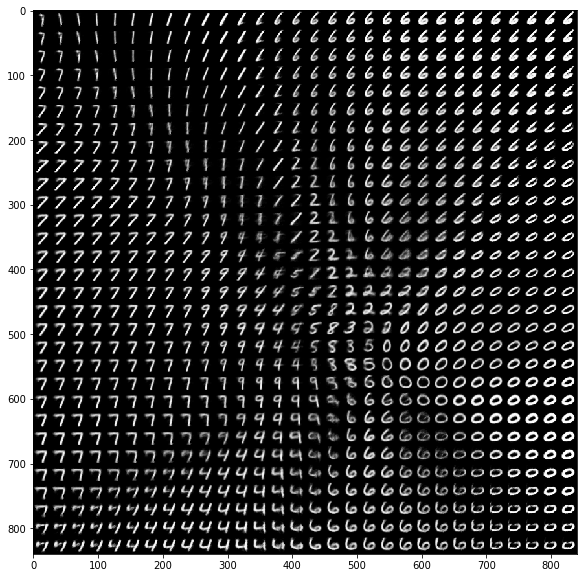

In [0]:
# 숫자의 2D manifold 출력 
n = 30  # 30x30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#sample z 
grid_x = np.linspace(X_MIN, X_MAX, n)
grid_y = np.linspace(Y_MIN, Y_MAX, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) 
        digit = np.array(dec(z_sample))
        digit = digit.reshape(28,28);
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

#n_dim = 3인 경우

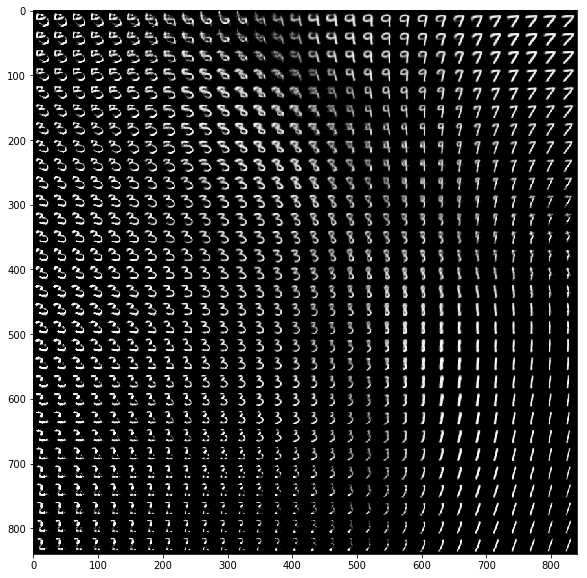

In [0]:
# 숫자의 2D manifold 출력 
n = 30  # 30x30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#sample z 
grid_x = np.linspace(X_MIN, X_MAX, n)
grid_y = np.linspace(Y_MIN, Y_MAX, n)
grid_z = np.linspace(Z_MIN, Z_MAX, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      for z, zi in enumerate(grid_z):
        z_sample = np.array([[xi, yi, zi]]) 
        digit = np.array(dec(z_sample))
        digit = digit.reshape(28,28);
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

#정리
- layer을 깊게 쌓으면 오히려 재구성된 숫자가 적게 쌓은 것 보다 좋지않은 결과를 볼 수 있었습니다.
- generative model에서 단순한 숫자인 mnist보다는 fashion-mnist에서 좀 더 다양한 결과를 볼 수 있었습니다.
- 이미지에 성능이 좋은 convolutional neural network을 인코더 / 디코더로 사용하면 더 좋은 결과물을 낼 수 있습니다.
- 의미있게 만들어진 이미지는 0과 1처럼 특징이 분명한 숫자들이 알아보기 쉬운 결과물이였고 3과 5처럼 비슷한 특징을 가진 숫자들은 구분이 힘든 결과물들이 있었습니다.
- 학습 속도는 convolution neural network가 dence에 비해 훨씬 느렸습니다.
- dence는 적은 학습 횟수에도 괜찮은 결과물이 나왔지만 convolution neural network는 좀 더 많은 학습을 해야 좋은 결과물이 나왔습니다.
- 일정 학습 횟수를 지나면 학습의 효율이 작아지는 것을 볼 수 있었습니다.
- 새로 학습을 할때마다 결과 값이 다르게 나왔습니다.
- embedding차원을 늘리면 discriminative해집니다.